In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from torch import nn
import torch.nn.functional as F
from callback import *
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold

IMG_PATH = 'train-jpg/'
LBL_PATH = 'train_v2.csv'
n_classes = 17
stats = [[0,0,0], [255.,255.,255.]]

sz = 128
bs=32

val_idxs = get_cv_idxs(len(os.listdir(IMG_PATH)))

def f2(preds, y):
    ret = fbeta_score(y, preds>0.2, beta=2, average='samples')
    return ret

def get_data(sz):
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv('.', 'train-jpg', 'train_v2.csv',bs, tfms, 
                                        val_idxs=val_idxs, 
                                        suffix='.jpg',
                                        test_name='test-jpg')
    return data

def predict(learn, name):
    pred,y =learn.TTA(is_test=True, n_aug=10)
    pred = np.mean(pred, 0)

    c = np.array(learn.data.classes)

    label_text = np.array([' '.join(c[p>0.2]) for p in pred])

    df = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
                       'tags': label_text})
    df.to_csv('subm.csv', index=False)
    
    df = pd.DataFrame(pred, columns=learn.data.classes)
    df.insert(0, 'id', [f[9:-4] for f in learn.data.test_ds.fnames])

    df.to_csv(name, index=False)

### image size 128

In [2]:
custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

model = ConvnetBuilder(resnet34, 0,0,0,custom_head=custom_head)

# learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
learn = ConvLearner(get_data(128), model, metrics=[f2])
learn.unfreeze()

In [3]:
learn.load('custom_128')

In [15]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 64

In [25]:
learn.lr_find()

epoch      trn_loss   val_loss   f2                            
    0      0.230308   0.331573   0.702583  



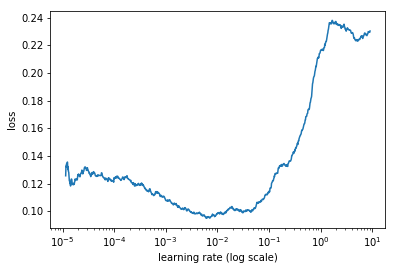

In [26]:
learn.sched.plot()

In [27]:
learn.fit(0.1,2, cycle_len=1)

  3%|▎         | 32/1012 [00:04<02:08,  7.63it/s, loss=0.135]


KeyboardInterrupt: 

In [8]:
# learn.unfreeze()

In [9]:
lr=1e-1
lrs=[lr/10,lr/4,lr]

In [10]:
learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), callbacks=[SaveBestModel(learn, lrs, 'custom_128', monitor='acc', patience=16)])

epoch      trn_loss   val_loss   f2                          
    0      0.116693   0.112287   0.899338  
    1      0.103709   0.099779   0.911744                    
    2      0.094999   0.095354   0.916973                     
    3      0.094564   0.092262   0.919437                     
    4      0.091572   0.092994   0.917815                     
    5      0.088058   0.089641   0.921947                     
    6      0.085725   0.089222   0.922025                     
    7      0.08344    0.089092   0.922423                     
    8      0.089096   0.093749   0.918647                     
    9      0.087546   0.092468   0.920027                     
    10     0.084749   0.089272   0.923108                     
    11     0.081926   0.088218   0.923391                     
    12     0.082213   0.089021   0.922958                     
    13     0.080689   0.087671   0.923823                     
    14     0.077772   0.089021   0.921909                     
    15     0.

[array([0.08858]), 0.9239746330433711]

In [13]:
pred,y =learn.TTA()

In [14]:
pred = np.mean(pred, 0)

In [27]:
pred,y= predict_with_targs(learn.model, learn.data.val_dl)

In [7]:
predict(learn, 'custom_128.csv')

In [29]:
fbeta_score(y, pred>0., beta=2, average='samples')

0.9258850841960182

In [70]:
pred,y =learn.TTA(is_test=True)
pred = np.mean(pred, 0)

c = np.array(learn.data.classes)

label_text = np.array([' '.join(c[p>thres_opt]) for p in pred])

df = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
                   'tags': label_text})

df.to_csv('subm.csv', index=False)

KeyboardInterrupt: 

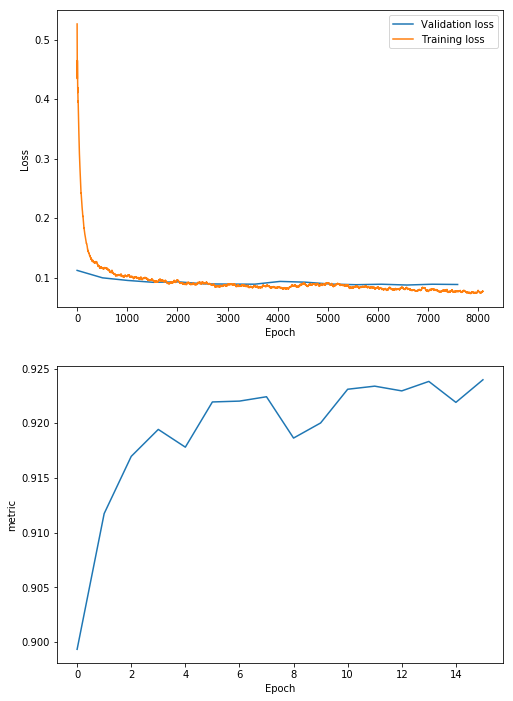

In [11]:
plot_trainval(learn)

### 256 resolution

In [9]:
custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

model = ConvnetBuilder(resnet34, 0,0,0,custom_head=custom_head)

# learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
learn = ConvLearner(get_data(256), model, metrics=[f2])
learn.unfreeze()

In [31]:
lr=2e-3
lrs=[lr/10,lr/4,lr]

In [32]:
learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), callbacks=[SaveBestModel(learn, lrs, 'custom_256', monitor='acc', patience=16)])

epoch      trn_loss   val_loss   f2                             
    0      0.094418   0.095894   0.914126  
    1      0.091812   0.090925   0.919679                       
    2      0.088523   0.089613   0.921741                       
    3      0.08587    0.08866    0.922446                       
    4      0.08555    0.088312   0.922779                       
    5      0.085462   0.088431   0.922258                       
    6      0.087149   0.088126   0.923384                       
    7      0.084775   0.087957   0.923235                       
    8      0.083709   0.087899   0.92374                        
    9      0.082303   0.086971   0.924639                       
    10     0.085699   0.087128   0.924001                       
    11     0.084534   0.087152   0.924669                       
    12     0.085653   0.087111   0.924944                       
    13     0.08248    0.087093   0.924049                       
    14     0.083027   0.087216   0.92431      

[array([0.08691]), 0.9253572970896609]

In [10]:
learn.load('custom_256')

In [17]:
predict(learn, 'custom_256.csv')

In [21]:
pred,y =learn.TTA(is_test=True)
pred = np.mean(pred, 0)

c = np.array(learn.data.classes)

label_text = np.array([' '.join(c[p>thres_opt]) for p in pred])

df = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
                   'tags': label_text})

df.to_csv('subm256.csv', index=False)

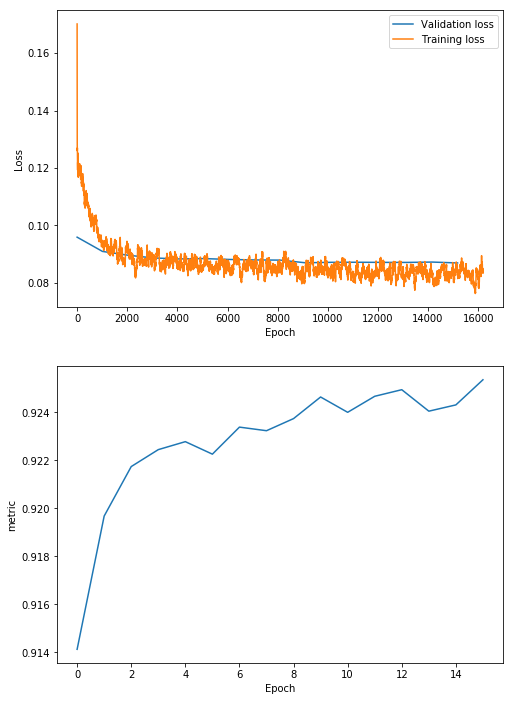

In [34]:
plot_trainval(learn)

### find optim f2 thres

In [4]:
def fbeta(y,p):
    return fbeta_score(y, p, beta=2, average='samples')
def get_optimal_threshhold(true_label, prediction, iterations = 100):

    best_threshhold = [0.2]*17    
    for t in range(17):
        best_fbeta = 0
        temp_threshhold = [0.2]*17
        for i in range(iterations):
            temp_value = i / float(iterations)
            temp_threshhold[t] = temp_value
            temp_fbeta = fbeta(true_label, prediction > temp_threshhold)
            if  temp_fbeta> best_fbeta:
                best_fbeta = temp_fbeta
                best_threshhold[t] = temp_value
    return best_threshhold

In [22]:
def get_trn_pred(learn, bs):
    pp=[]
    yy=[]
    for x,y in iter(learn.data.trn_dl):
        learn.model.eval()
        p = to_np(learn.model(VV(x)))
        pp.append(p)
        yy.append(to_np(y))
    return np.concatenate(pp, 0), np.concatenate(yy, 0)

In [23]:
val_p, val_y = get_trn_pred(learn, bs)

In [24]:
thres_opt = get_optimal_threshhold(val_y, val_p)

/home/cvpr/SSDDisk/torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cvpr/SSDDisk/torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cvpr/SSDDisk/torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cvpr/SSDDisk/torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cvpr/SSDDisk/t

In [25]:
fbeta_score(val_y, val_p>thres_opt, beta=2, average='samples')

0.932283438732341

In [26]:
thres_opt

[0.17,
 0.32,
 0.19,
 0.27,
 0.17,
 0.15,
 0.1,
 0.27,
 0.19,
 0.16,
 0.17,
 0.16,
 0.3,
 0.2,
 0.16,
 0.17,
 0.18]

In [20]:
np.sum(pred-val_p)

0.0

In [40]:
fbeta(np.zeros((1,17))+1, np.random.uniform(size=(1,17))>1)

/home/cvpr/SSDDisk/torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted labels.
  'precision', 'predicted', average, warn_for)


0.0